<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Intent" data-toc-modified-id="Intent-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Intent</a></span></li><li><span><a href="#Learnings" data-toc-modified-id="Learnings-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Learnings</a></span></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Dimensionality-Reduction" data-toc-modified-id="Dimensionality-Reduction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dimensionality Reduction</a></span><ul class="toc-item"><li><span><a href="#RFE-Feature-Elimination" data-toc-modified-id="RFE-Feature-Elimination-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RFE Feature Elimination</a></span></li></ul></li><li><span><a href="#SGD-on-Top-Features" data-toc-modified-id="SGD-on-Top-Features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SGD on Top Features</a></span><ul class="toc-item"><li><span><a href="#Predict-&amp;-Visualize-SGD" data-toc-modified-id="Predict-&amp;-Visualize-SGD-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Predict &amp; Visualize SGD</a></span></li><li><span><a href="#SGD-Parameter-Tuning" data-toc-modified-id="SGD-Parameter-Tuning-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>SGD Parameter Tuning</a></span></li></ul></li></ul></div>

## Summary

### Intent

The intent of this notebook is to explore regression models on the BAV dataset. The goal to identify the ideal model to predict the score of a brand to be "Recommended to Friend"—attribute used as a proxy for brand strength.   

In addition to the modelling itself, this notebook explores the result of various dimensionality reduction techniques in conjunction with the various models.

### Learnings

Note for Paolo: 1 of 3 models attempted so far. Rough Plan:

1. SGD with top 10 features identified through Feature Elimation
2. Random Forrest with top features identified/grouped through Factor Analysis
3. Logistic Regression with top features identified through High Correlation filtering and/or Low Variance Filtering

Then some type of approach to select the best/most appropriate combination.

## Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import os
import requests
import numpy as np
import time

from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

In [2]:
# Read in data from pre-processing stage
BAV_df = pd.read_csv("../data/BAV_unscaled.csv")
BAV_scaled = pd.read_csv("../data/BAV_scaled.csv")

## Dimensionality Reduction

### RFE Feature Elimination

In [3]:
BAV_df = BAV_df.set_index('Unnamed: 0')
BAV_df.index.rename('Brand', inplace=True)
BAV_df.head()

,Recommend_to_a_friend_pct,Energized_Differentiation_C,Relevance_C,Esteem_C,Knowledge_C,Brand_Stature_C,Brand_Strength_C,Different_pct,Distinctive_pct,Unique_pct,...,Stylish_pct,Traditional_pct,Trendy_pct,Trustworthy_pct,Unapproachable_pct,Up_To_Date_pct,Upper_Class_pct,Visionary_pct,Worth_More_pct,yr_2019
Brand,,,,,,,,,,,,,,,,,,,,,
Acura,9.632626,0.588681,2.131318,0.536944,3.303892,1.774005,1.254666,8.081687,12.271390,8.301122,...,15.710160,6.446314,14.55371,16.099440,5.703656,11.032270,15.302950,12.951940,6.352579,0
Alfa Romeo,5.360558,0.771191,1.648400,0.351125,2.040411,0.716439,1.271231,11.130420,17.817520,13.124450,...,17.267210,7.225183,14.87083,9.865144,10.311310,10.518590,25.941139,9.230522,8.130341,0
Aston Martin,6.165359,0.777430,1.568270,0.347223,2.272228,0.788971,1.219220,11.082860,18.486561,13.061050,...,16.646311,5.149739,12.15355,9.925730,9.625601,7.878853,30.506660,10.001760,8.295667,0
Audi,8.403893,0.773740,1.970076,0.536370,3.247704,1.741970,1.524328,9.503444,16.048050,11.872650,...,18.800541,8.386318,15.85582,12.400040,6.730000,10.951970,21.809719,11.357830,8.388798,0
Bentley,6.453038,0.790917,1.605834,0.500165,2.720615,1.360756,1.270082,11.227820,19.309050,14.956740,...,19.569870,11.032830,12.52582,12.685470,11.473560,9.141562,34.941780,9.720911,10.133530,0


In [4]:
# Isolate features and target
# Unscaled data
X = BAV_df.drop(['Recommend_to_a_friend_pct'], axis=1)
y = BAV_df['Recommend_to_a_friend_pct']

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X, y)
selector.get_params

<bound method BaseEstimator.get_params of RFE(estimator=SVR(kernel='linear'), n_features_to_select=10)>

In [5]:
# Look at the ranking of all thea features
# 1s indicate the index of a top 10 feature
selector.ranking_

array([46,  1,  1,  1,  1,  7, 30, 29, 42, 38,  1,  3, 16, 12, 17, 39,  1,
       28, 18, 36, 24, 26, 14, 25, 37,  5,  4, 33, 22, 44, 45, 19, 43, 41,
       34, 27,  8, 32, 31,  6, 23,  1, 11,  9, 40, 21,  2,  1, 35,  1, 15,
       13, 20,  1, 10])

In [11]:
# Map top features to column names
ranked_feats = pd.DataFrame(data={'Feature': np.array(X.columns), 'Ranking': np.array(selector.ranking_)})
top_feats = ranked_feats.loc[ranked_feats['Ranking']==1]
top_feats.head(10)

,Feature,Ranking
1,Relevance_C,1
2,Esteem_C,1
3,Knowledge_C,1
4,Brand_Stature_C,1
10,Innovative_pct,1
16,Best_Brand_pct,1
41,Simple_pct,1
47,Trendy_pct,1
49,Unapproachable_pct,1
53,Worth_More_pct,1


## SGD on Top Features

In [15]:
# Reduce to top features according to SVR
X_top = X[top_feats.Feature.to_list()]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2)
model_sgd = SGDRegressor(max_iter=100000, tol=1e-5) # Starting point, will fine-tune next
model_sgd.fit(X_train, y_train)
model_sgd.score(X_train, y_train)

-0.02400533259401283

In [57]:
model_sgd.predict(X_test)

array([18.69625732, -0.111874  ,  4.3741148 , ...,  2.41557275,
       -4.96096907, 10.55481633])

### Predict & Visualize SGD

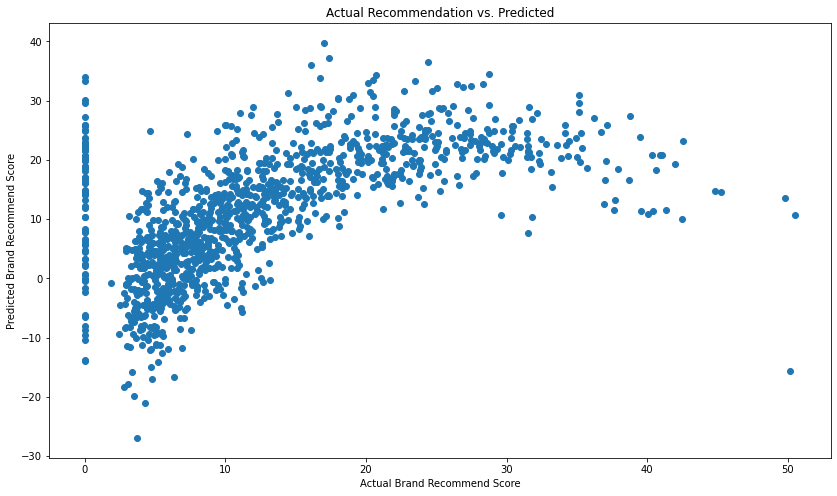

Mean Squared Error :82.76886854189472
Mean Absolute Error :6.609928308509032


In [58]:
figure(figsize=(14, 8))
plt.scatter(y_test, model_sgd.predict(X_test))
plt.title('Actual Recommendation vs. Predicted')
plt.xlabel('Actual Brand Recommend Score')
plt.ylabel('Predicted Brand Recommend Score')
plt.show()

print('Mean Squared Error :{}'.format(mean_squared_error(y_test, model_sgd.predict(X_test))))
print('Mean Absolute Error :{}'.format(mean_absolute_error(y_test, model_sgd.predict(X_test))))

### SGD Parameter Tuning

In [46]:
# Fine tuning to optimize learning rate and number of iterations